# 1 Without feature selection, hyperparam search & no text features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import nltk
from nltk.corpus import stopwords
import optuna
from pandas import to_datetime
from sklearn.feature_selection import SelectFromModel

from src.constants import EVAL_WINDOWS, TEST_TIME_LOWER_BOUND
from src.utils import (create_expanding_splits, 
                       create_lag_features, 
                       create_rolling_features, 
                       clean_text, 
                       get_data, 
                       add_text_sentiment,
                       pnl)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/temirlanzholaman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1.1 all features + 1,2,3,5,15,30, 60 lags

from PACF in arima it seems that there is no much autocorreleation for larger times, but I will test them anyways


Overall timestamp range in data: 2023-01-01 16:39:00 to 2024-08-31 23:58:00


[I 2025-02-03 09:19:40,304] A new study created in memory with name: no-name-af6366bc-ea89-4c04-8cc4-bd8b0f4a157b
/Users/temirlanzholaman/anaconda3/envs/potykal/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-03 09:19:40,550] Trial 0 finished with value: 0.001151548551724848 and parameters: {'eta': 0.09501417128409355, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.6091367900930329, 'colsample_bytree': 0.5263372060775673}. Best is trial 0 with value: 0.001151548551724848.
/Users/temirlanzholaman/anaconda3/envs/potykal/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-

Best hyperparameters (spread): {'eta': 0.021194530240064204, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.9309093313937085, 'colsample_bytree': 0.6813351536048657}

Rolling validation (spread):
Fold 1:
  (Training up to 2024-01-01)
  Validation period: 2024-03-01 00:00:00 to 2024-03-31 23:59:00
  Fold 1 Validation MSE (spread): 0.000001

Fold 2:
  (Training up to 2024-02-01)
  Validation period: 2024-04-01 00:00:00 to 2024-04-30 23:59:00
  Fold 2 Validation MSE (spread): 0.000001

Fold 3:
  (Training up to 2024-03-01)
  Validation period: 2024-05-01 00:00:00 to 2024-05-31 23:59:00
  Fold 3 Validation MSE (spread): 0.000001

Fold 4:
  (Training up to 2024-04-01)
  Validation period: 2024-06-01 00:00:00 to 2024-06-30 23:59:00
  Fold 4 Validation MSE (spread): 0.000001

Fold 5:
  (Training up to 2024-05-01)
  Validation period: 2024-07-01 00:00:00 to 2024-07-31 23:59:00
  Fold 5 Validation MSE (spread): 0.000001

Average Validation MSE across folds (spread): 9.22722731666666e-07


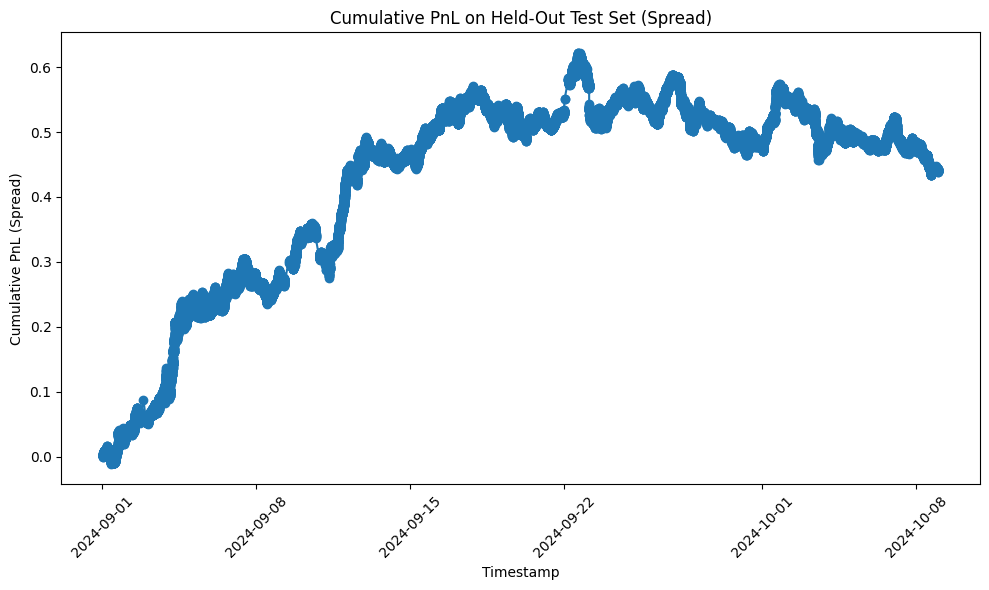

Test MSE (close): 0.036071


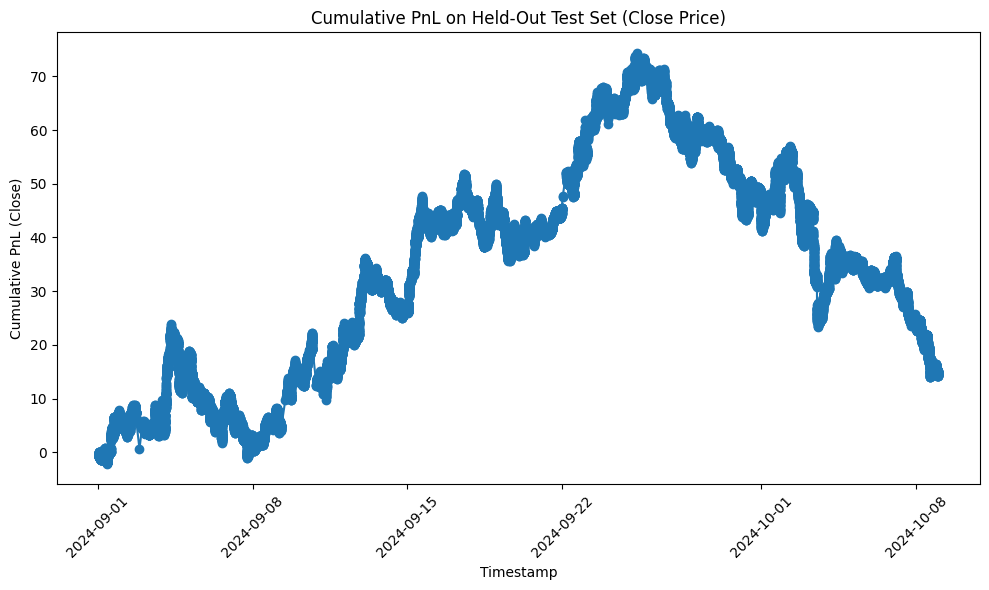

In [2]:
ts_data_path = 'remaining_data_v1.csv'
text_data_path = 'coin_tweets_share.csv'
LAGS = [1, 2, 3, 4, 5, 10, 15, 30, 60]
df_ts = pd.read_csv(ts_data_path, parse_dates=['date', 'timestamp'])
df_text = pd.read_csv(text_data_path, parse_dates=['timestamp'])
df_text['minute'] = df_text['timestamp'].dt.floor('min')

df = df_ts
df = create_lag_features(df, 'spread', lags=LAGS)
df = create_lag_features(df, 'volume', lags=LAGS)
df = create_rolling_features(df, 'spread', window=5)

df['target'] = df['spread'].shift(-1) - df['spread']
df['target_close'] = df['close'].shift(-1) - df['close']
df.dropna(inplace=True)

print("Overall timestamp range in data:", df['timestamp'].min(), "to", df['timestamp'].max())

val_windows = EVAL_WINDOWS
folds = create_expanding_splits(df, val_windows, date_col="timestamp", gap_months=2)
fold_results = []

if folds:
    train_fold, val_fold = folds[0]
    feature_cols = [col for col in df.columns if col not in ['date', 'target', 'target_close', 'timestamp', 'Unnamed: 0']]
    X_train_fold = train_fold[feature_cols]
    y_train_fold = train_fold['target']
    X_val_fold = val_fold[feature_cols]
    y_val_fold = val_fold['target']
    
    dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold)
    dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold)
    
    def objective(trial):
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'seed': 42
        }
        model = xgb.train(params, dtrain_fold, num_boost_round=500,
                          evals=[(dval_fold, 'eval')], early_stopping_rounds=10, verbose_eval=False)
        preds = model.predict(dval_fold)
        rmse = mean_squared_error(y_val_fold, preds, squared=False)
        return rmse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    best_params = study.best_trial.params
    print("Best hyperparameters (spread):", best_params)
else:
    best_params = {
        'eta': 0.1,
        'max_depth': 5,
        'min_child_weight': 1,
        'subsample': 1.0,
        'colsample_bytree': 1.0
    }
    print("No folds available for tuning; using default parameters.")

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42,
    **best_params
}

print("\nRolling validation (spread):")
for i, (train_df, val_df) in enumerate(folds):
    print(f"Fold {i+1}:")
    gap_info = f"(Training up to {(EVAL_WINDOWS[i][0] - pd.DateOffset(months=2)).strftime('%Y-%m-%d')})"
    print("  " + gap_info)
    if val_df.empty:
        print(f"  Fold {i+1}: Validation set is empty. Skipping this fold.\n")
        continue
    print(f"  Validation period: {val_df['timestamp'].min()} to {val_df['timestamp'].max()}")
    
    feature_cols = [col for col in df.columns if col not in ['date', 'target', 'target_close', 'timestamp', 'Unnamed: 0']]
    X_train = train_df[feature_cols]
    y_train = train_df['target']
    X_val = val_df[feature_cols]
    y_val = val_df['target']
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    evals_list = [(dtrain, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrain, num_boost_round=1000,
                      evals=evals_list, early_stopping_rounds=20, verbose_eval=False)
    
    val_pred = model.predict(dval)
    mse_val = mean_squared_error(y_val, val_pred)
    print(f"  Fold {i+1} Validation MSE (spread): {mse_val:.6f}\n")
    fold_results.append(mse_val)

if fold_results:
    print("Average Validation MSE across folds (spread):", np.mean(fold_results))
else:
    print("No valid folds were found. Please adjust your validation windows.")

final_train_df = df[df['timestamp'] < (TEST_TIME_LOWER_BOUND - pd.DateOffset(months=2))]
feature_cols = [col for col in df.columns if col not in ['date', 'target', 'target_close', 'timestamp', 'Unnamed: 0']]

X_all = final_train_df[feature_cols]
y_all = final_train_df['target']
dall = xgb.DMatrix(X_all, label=y_all)

# Train final model for spread
model_all = xgb.train(params, dall, num_boost_round=1000,
                      evals=[(dall, 'train')], early_stopping_rounds=20, verbose_eval=False)

# Load test 
test_df = get_data('test_data.csv')
test_df['timestamp'] = test_df['timestamp'].dt.floor('min')
test_df = create_lag_features(test_df, 'spread', lags=LAGS)
test_df = create_lag_features(test_df, 'volume', lags=LAGS)
test_df = create_rolling_features(test_df, 'spread', window=5)
test_df['target'] = test_df['spread'].shift(-1) - test_df['spread']
test_df['target_close'] = test_df['close'].shift(-1) - test_df['close']
test_df.dropna(inplace=True)

X_test = test_df[feature_cols]
y_test = test_df['target']
dtest = xgb.DMatrix(X_test, label=y_test)

test_pred = model_all.predict(dtest)
mse_test = mean_squared_error(y_test, test_pred)
print(f"\nTest MSE (spread): {mse_test:.6f}")

# Trading evaluation (Spread)
test_df['predicted_return'] = test_pred
test_df['pos_size'] = np.where(test_df['predicted_return'] > 0, 1, -1)
test_df = pnl(test_df, pos_col='pos_size', price_col='spread')

plt.figure(figsize=(10, 6))
plt.plot(test_df['timestamp'], test_df['cumulative_pnl'], marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative PnL (Spread)')
plt.title('Cumulative PnL on Held-Out Test Set (Spread)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Training and Evaluation on Close Price
X_all_close = final_train_df[feature_cols]
y_all_close = final_train_df['target_close']
dall_close = xgb.DMatrix(X_all_close, label=y_all_close)

model_all_close = xgb.train(params, dall_close, num_boost_round=1000,
                            evals=[(dall_close, 'train')], early_stopping_rounds=20, verbose_eval=False)

X_test_close = test_df[feature_cols]
y_test_close = test_df['target_close']
dtest_close = xgb.DMatrix(X_test_close, label=y_test_close)

test_pred_close = model_all_close.predict(dtest_close)
mse_test_close = mean_squared_error(y_test_close, test_pred_close)
print(f"Test MSE (close): {mse_test_close:.6f}")

# Trading evaluation (Close Price)
test_df['predicted_return_close'] = test_pred_close
test_df['pos_size_close'] = np.where(test_df['predicted_return_close'] > 0, 1, -1)
# Compute PnL using 'close' as the trading price
test_df_close = test_df.copy()
test_df_close = pnl(test_df_close, pos_col='pos_size_close', price_col='close')

plt.figure(figsize=(10, 6))
plt.plot(test_df_close['timestamp'], test_df_close['cumulative_pnl'], marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative PnL (Close)')
plt.title('Cumulative PnL on Held-Out Test Set (Close Price)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 1.2 Let's try adding textual features

/var/folders/d4/kmvfs86566qdvphh5mdyn9lw0000gn/T/ipykernel_98472/802660714.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_ts['timestamp'] = df_ts['timestamp'].dt.floor('T')


Overall timestamp range in data: 2023-01-01 16:39:00 to 2024-08-31 23:58:00


[I 2025-02-03 09:28:33,815] A new study created in memory with name: no-name-76ff2e28-aee1-4dc8-9b4b-5cbc8f4b6323
/Users/temirlanzholaman/anaconda3/envs/potykal/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-03 09:28:34,208] Trial 0 finished with value: 0.0011199047616801147 and parameters: {'eta': 0.08654326508456577, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.8970169193176372, 'colsample_bytree': 0.868441668173255}. Best is trial 0 with value: 0.0011199047616801147.
/Users/temirlanzholaman/anaconda3/envs/potykal/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025

Best hyperparameters (spread): {'eta': 0.014394163659302949, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.9384167350137407, 'colsample_bytree': 0.7776018008348005}

Rolling validation (spread):
Fold 1:
  (Training up to 2024-01-01)
  Validation period: 2024-03-01 00:00:00 to 2024-03-31 23:59:00
  Fold 1 Validation MSE (spread): 0.000001

Fold 2:
  (Training up to 2024-02-01)
  Validation period: 2024-04-01 00:00:00 to 2024-04-30 23:59:00
  Fold 2 Validation MSE (spread): 0.000001

Fold 3:
  (Training up to 2024-03-01)
  Validation period: 2024-05-01 00:00:00 to 2024-05-31 23:59:00
  Fold 3 Validation MSE (spread): 0.000001

Fold 4:
  (Training up to 2024-04-01)
  Validation period: 2024-06-01 00:00:00 to 2024-06-30 23:59:00
  Fold 4 Validation MSE (spread): 0.000001

Fold 5:
  (Training up to 2024-05-01)
  Validation period: 2024-07-01 00:00:00 to 2024-07-31 23:59:00
  Fold 5 Validation MSE (spread): 0.000001

Average Validation MSE across folds (spread): 8.838614567442173e-07

/var/folders/d4/kmvfs86566qdvphh5mdyn9lw0000gn/T/ipykernel_98472/802660714.py:124: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  test_df['timestamp'] = test_df['timestamp'].dt.floor('T')


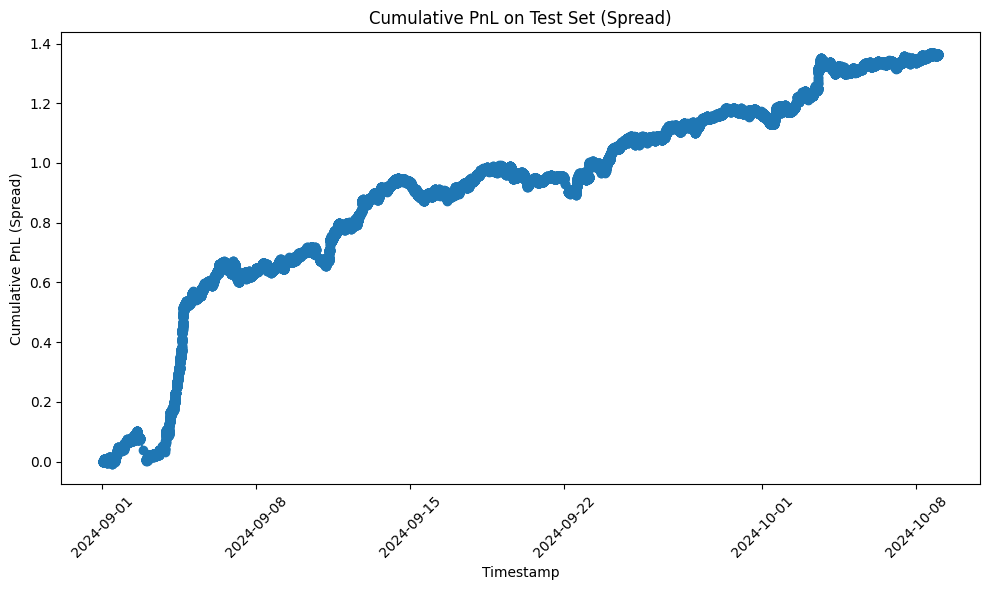

Test MSE (close): 0.033742


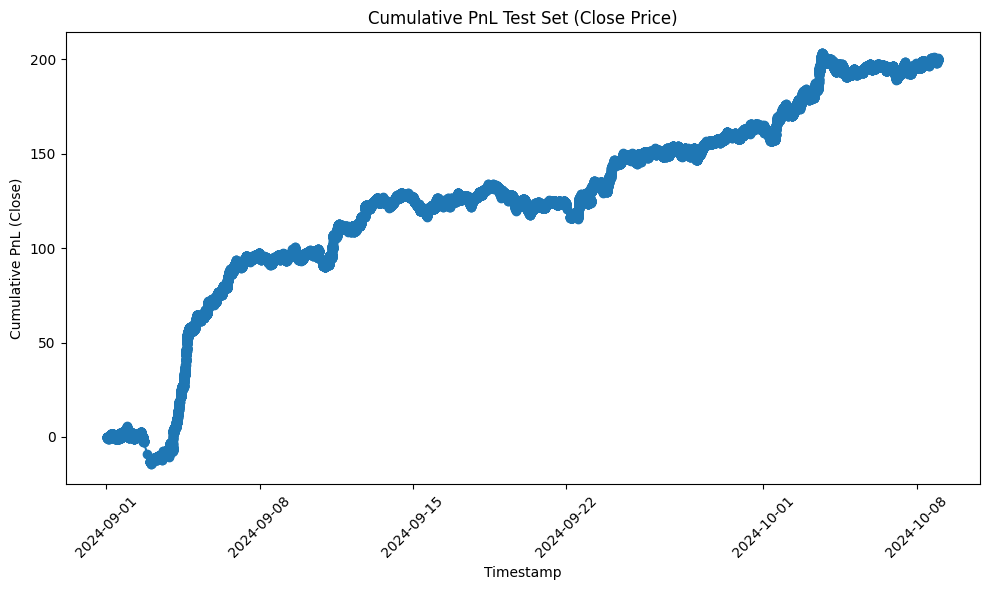

In [11]:
ts_data_path = 'remaining_data_v1.csv'
text_data_path = 'coin_tweets_share.csv'

df_ts = pd.read_csv(ts_data_path, parse_dates=['date', 'timestamp'])
df_text = pd.read_csv(text_data_path, parse_dates=['timestamp'])
df_text = add_text_sentiment(df_text, text_col='post_text')
df_text['minute'] = df_text['timestamp'].dt.floor('min')
sentiment_min = df_text.groupby('minute')['sentiment'].mean().reset_index()
sentiment_min.columns = ['timestamp', 'avg_sentiment']
df_ts['timestamp'] = df_ts['timestamp'].dt.floor('T')

df = pd.merge(df_ts, sentiment_min, on='timestamp', how='left')
df['avg_sentiment'] = df['avg_sentiment'].fillna(0)

df = create_lag_features(df, 'spread', lags=LAGS)
df = create_lag_features(df, 'volume', lags=LAGS)
df = create_rolling_features(df, 'spread', window=5)
df = create_lag_features(df, 'avg_sentiment', lags=LAGS)

df['target'] = df['spread'].shift(-1) - df['spread']
df['target_close'] = df['close'].shift(-1) - df['close']
df.dropna(inplace=True)

print("Overall timestamp range in data:", df['timestamp'].min(), "to", df['timestamp'].max())

val_windows = EVAL_WINDOWS
folds = create_expanding_splits(df, val_windows, date_col="timestamp", gap_months=2)
fold_results = []

if folds:
    train_fold, val_fold = folds[0]
    feature_cols = [col for col in df.columns if col not in ['date', 'target', 'target_close', 'timestamp', 'Unnamed: 0']]
    X_train_fold = train_fold[feature_cols]
    y_train_fold = train_fold['target']
    X_val_fold = val_fold[feature_cols]
    y_val_fold = val_fold['target']
    
    dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold)
    dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold)
    
    def objective(trial):
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'seed': 42
        }
        model = xgb.train(params, dtrain_fold, num_boost_round=500,
                          evals=[(dval_fold, 'eval')], early_stopping_rounds=10, verbose_eval=False)
        preds = model.predict(dval_fold)
        rmse = mean_squared_error(y_val_fold, preds, squared=False)
        return rmse

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    best_params = study.best_trial.params
    print("Best hyperparameters (spread):", best_params)
else:
    best_params = {
        'eta': 0.1,
        'max_depth': 5,
        'min_child_weight': 1,
        'subsample': 1.0,
        'colsample_bytree': 1.0
    }
    print("No folds available for tuning; using default parameters.")

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42,
    **best_params
}

print("\nRolling validation (spread):")
for i, (train_df, val_df) in enumerate(folds):
    print(f"Fold {i+1}:")
    gap_info = f"(Training up to {(EVAL_WINDOWS[i][0] - pd.DateOffset(months=2)).strftime('%Y-%m-%d')})"
    print("  " + gap_info)
    if val_df.empty:
        print(f"  Fold {i+1}: Validation set is empty. Skipping this fold.\n")
        continue
    print(f"  Validation period: {val_df['timestamp'].min()} to {val_df['timestamp'].max()}")
    
    feature_cols = [col for col in df.columns if col not in ['date', 'target', 'target_close', 'timestamp', 'Unnamed: 0']]
    X_train = train_df[feature_cols]
    y_train = train_df['target']
    X_val = val_df[feature_cols]
    y_val = val_df['target']
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    evals_list = [(dtrain, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrain, num_boost_round=1000,
                      evals=evals_list, early_stopping_rounds=20, verbose_eval=False)
    
    val_pred = model.predict(dval)
    mse_val = mean_squared_error(y_val, val_pred)
    print(f"  Fold {i+1} Validation MSE (spread): {mse_val:.6f}\n")
    fold_results.append(mse_val)

if fold_results:
    print("Average Validation MSE across folds (spread):", np.mean(fold_results))
else:
    print("No valid folds were found. Please adjust your validation windows.")

final_train_df = df[df['timestamp'] < (TEST_TIME_LOWER_BOUND - pd.DateOffset(months=2))]
feature_cols = [col for col in df.columns if col not in ['date', 'target', 'target_close', 'timestamp', 'Unnamed: 0']]

X_all = final_train_df[feature_cols]
y_all = final_train_df['target']
dall = xgb.DMatrix(X_all, label=y_all)

# Train final model for spread
model_all = xgb.train(params, dall, num_boost_round=1000,
                      evals=[(dall, 'train')], early_stopping_rounds=20, verbose_eval=False)

test_df = get_data('test_data.csv')
test_df['timestamp'] = test_df['timestamp'].dt.floor('T')
test_df = pd.merge(test_df, sentiment_min, on='timestamp', how='left')
test_df['avg_sentiment'] = test_df['avg_sentiment'].fillna(0)
test_df = create_lag_features(test_df, 'spread', lags=LAGS)
test_df = create_lag_features(test_df, 'volume', lags=LAGS)
test_df = create_rolling_features(test_df, 'spread', window=5)
test_df = create_lag_features(test_df, 'avg_sentiment', lags=LAGS)
test_df['target'] = test_df['spread'].shift(-1) - test_df['spread']
test_df['target_close'] = test_df['close'].shift(-1) - test_df['close']
test_df.dropna(inplace=True)

X_test = test_df[feature_cols]
y_test = test_df['target']
dtest = xgb.DMatrix(X_test, label=y_test)

test_pred = model_all.predict(dtest)
mse_test = mean_squared_error(y_test, test_pred)
print(f"\nTest MSE (spread): {mse_test:.6f}")

# Trading evaluation (Spread)
test_df['predicted_return'] = test_pred
test_df['pos_size'] = np.where(test_df['predicted_return'] > 0, 1, -1)
test_df = pnl(test_df, pos_col='pos_size', price_col='spread')
# test_to_save = test_df.copy()

plt.figure(figsize=(10, 6))
plt.plot(test_df['timestamp'], test_df['cumulative_pnl'], marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative PnL (Spread)')
plt.title('Cumulative PnL on Test Set (Spread)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Training and Evaluation on Close Price
X_all_close = final_train_df[feature_cols]
y_all_close = final_train_df['target_close']
dall_close = xgb.DMatrix(X_all_close, label=y_all_close)

model_all_close = xgb.train(params, dall_close, num_boost_round=1000,
                            evals=[(dall_close, 'train')], early_stopping_rounds=20, verbose_eval=False)

X_test_close = test_df[feature_cols]
y_test_close = test_df['target_close']
dtest_close = xgb.DMatrix(X_test_close, label=y_test_close)

test_pred_close = model_all_close.predict(dtest_close)
mse_test_close = mean_squared_error(y_test_close, test_pred_close)
print(f"Test MSE (close): {mse_test_close:.6f}")

test_df['predicted_return_close'] = test_pred_close
test_df['pos_size_close'] = np.where(test_df['predicted_return_close'] > 0, 1, -1)
test_df_close = test_df.copy()
test_df_close = pnl(test_df_close, pos_col='pos_size_close', price_col='close')

plt.figure(figsize=(10, 6))
plt.plot(test_df_close['timestamp'], test_df_close['cumulative_pnl'], marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative PnL (Close)')
plt.title('Cumulative PnL Test Set (Close Price)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
xd = test_df[['date', 'cumulative_pnl']]
xd.columns = ['date', 'boosting_all_spread']


In [21]:
xd2 = test_df_close[['date', 'cumulative_pnl']]
xd2.columns = ['date', 'boosting_all_close']

In [24]:
tot_data = pd.read_csv('tot_data.csv', parse_dates=['date']).drop('Unnamed: 0', axis=1)

In [28]:
tot_data = pd.merge(tot_data, pd.merge(xd, xd2))
tot_data.to_csv('tot_data.csv')

well text features adds up kinda a lot...

## 1.3 Feature selection time!

will do some simple feature importance from xgb & selector from sklearn

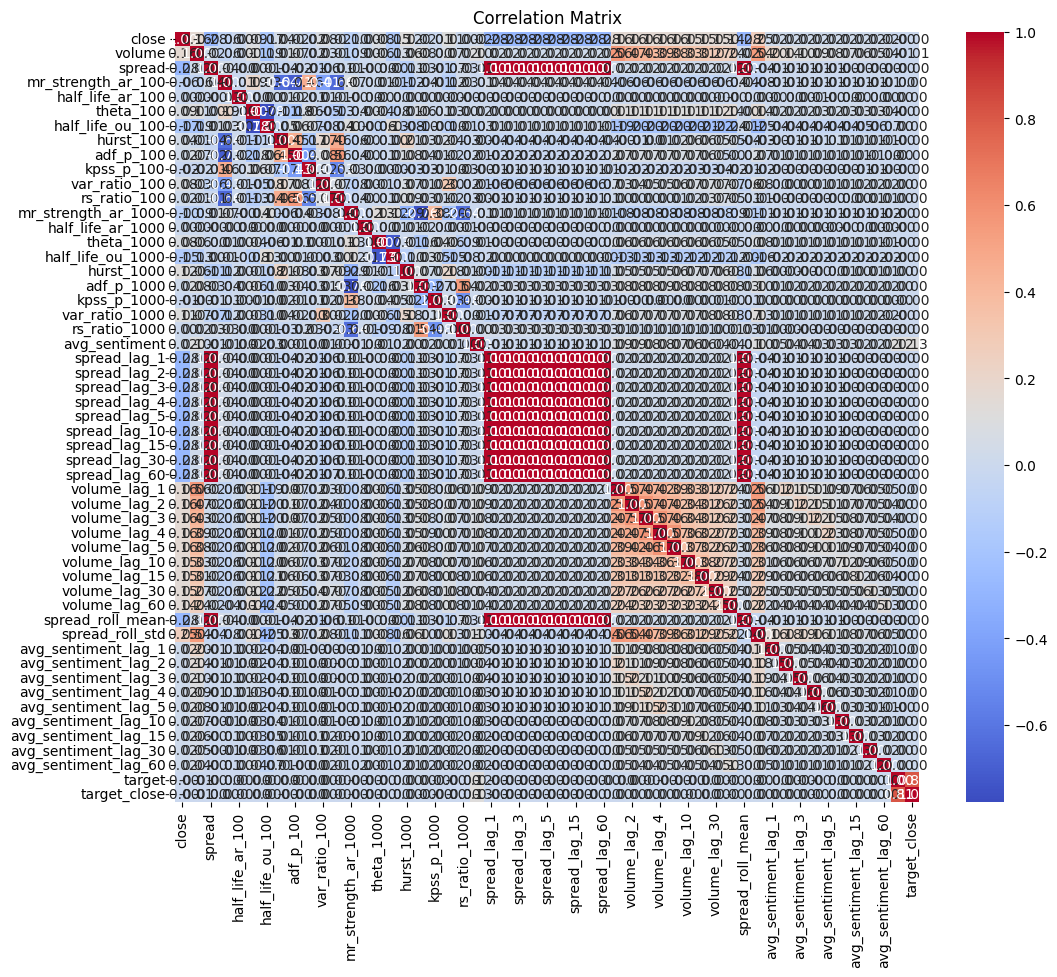

Correlation with target (absolute values):
target                  1.000000
target_close            0.807104
avg_sentiment           0.117777
volume                  0.010396
volume_lag_3            0.004230
avg_sentiment_lag_3     0.003550
avg_sentiment_lag_2     0.003480
spread_roll_std         0.003193
half_life_ar_1000       0.003128
volume_lag_2            0.002681
var_ratio_100           0.002613
theta_100               0.002407
spread_lag_60           0.002022
avg_sentiment_lag_1     0.002016
spread                  0.002005
avg_sentiment_lag_30    0.001969
spread_lag_30           0.001960
spread_lag_5            0.001937
spread_lag_15           0.001931
spread_roll_mean        0.001929
spread_lag_3            0.001916
spread_lag_4            0.001912
spread_lag_10           0.001909
spread_lag_1            0.001908
spread_lag_2            0.001904
avg_sentiment_lag_15    0.001853
close                   0.001742
volume_lag_15           0.001735
avg_sentiment_lag_10    0.001488


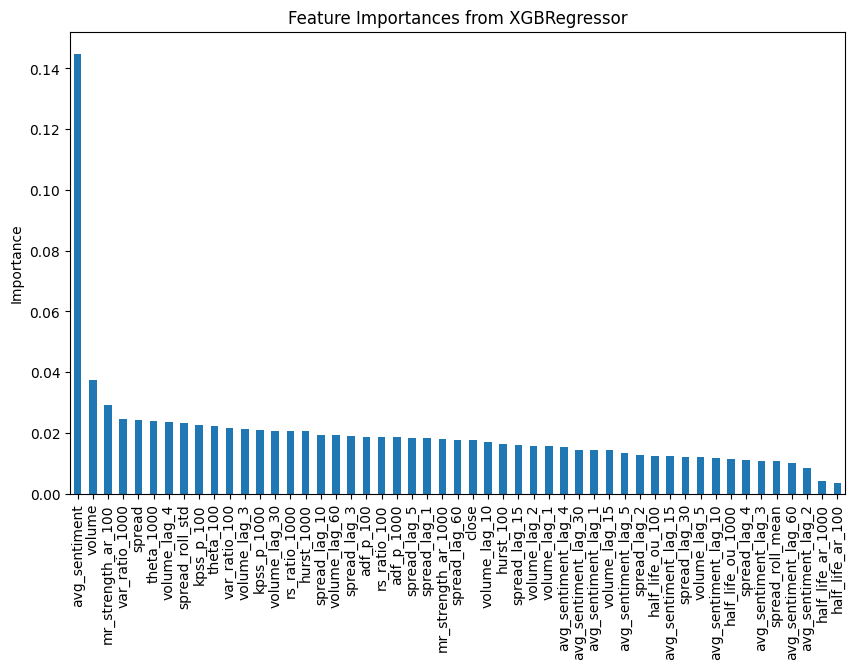

Selected features based on model importance:
['close', 'volume', 'spread', 'mr_strength_ar_100', 'theta_100', 'half_life_ou_100', 'hurst_100', 'adf_p_100', 'kpss_p_100', 'var_ratio_100', 'rs_ratio_100', 'mr_strength_ar_1000', 'theta_1000', 'half_life_ou_1000', 'hurst_1000', 'adf_p_1000', 'kpss_p_1000', 'var_ratio_1000', 'rs_ratio_1000', 'avg_sentiment', 'spread_lag_1', 'spread_lag_2', 'spread_lag_3', 'spread_lag_4', 'spread_lag_5', 'spread_lag_10', 'spread_lag_15', 'spread_lag_30', 'spread_lag_60', 'volume_lag_1', 'volume_lag_2', 'volume_lag_3', 'volume_lag_4', 'volume_lag_5', 'volume_lag_10', 'volume_lag_15', 'volume_lag_30', 'volume_lag_60', 'spread_roll_mean', 'spread_roll_std', 'avg_sentiment_lag_1', 'avg_sentiment_lag_3', 'avg_sentiment_lag_4', 'avg_sentiment_lag_5', 'avg_sentiment_lag_10', 'avg_sentiment_lag_15', 'avg_sentiment_lag_30']


In [6]:
LAGS = [1, 2, 3, 4, 5, 10, 15, 30, 60]


df_fs = df.drop(columns=['Unnamed: 0', 'timestamp', 'date'])
corr_matrix = df_fs.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

target_corr = corr_matrix['target'].abs().sort_values(ascending=False)
print("Correlation with target (absolute values):")
print(target_corr)

X = df_fs.drop(columns=['target', 'target_close'])
y = df_fs['target']

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X, y)

# Get and plot feature importances
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title("Feature Importances from XGBRegressor")
plt.ylabel("Importance")
plt.show()

# Use SelectFromModel to automatically choose features above a given threshold.
# You can adjust the threshold (here we use 0.01 as an example).
selector = SelectFromModel(xgb_model, threshold=0.01, prefit=True)
selected_features = X.columns[selector.get_support()]
print("Selected features based on model importance:")
print(selected_features.tolist())


In [7]:
ts_data_path = 'remaining_data_v1.csv'
text_data_path = 'coin_tweets_share.csv'
df_ts = pd.read_csv(ts_data_path, parse_dates=['date', 'timestamp'])
df_text = pd.read_csv(text_data_path, parse_dates=['timestamp'])
df_text = add_text_sentiment(df_text, text_col='post_text')
df_text['minute'] = df_text['timestamp'].dt.floor('min')
sentiment_min = df_text.groupby('minute')['sentiment'].mean().reset_index()
sentiment_min.columns = ['timestamp', 'avg_sentiment']

df_ts['timestamp'] = df_ts['timestamp'].dt.floor('T')
df = pd.merge(df_ts, sentiment_min, on='timestamp', how='left')
df['avg_sentiment'] = df['avg_sentiment'].fillna(0)

df = create_lag_features(df, 'spread', lags=LAGS)
df = create_lag_features(df, 'volume', lags=LAGS)
df = create_rolling_features(df, 'spread', window=5)
df = create_lag_features(df, 'avg_sentiment', lags=LAGS)  # sentiment lag
df['target'] = df['spread'].shift(-1) - df['spread']
df['target_close'] = df['close'].shift(-1) - df['close']
df.dropna(inplace=True)

print("Overall timestamp range in data:", df['timestamp'].min(), "to", df['timestamp'].max())


Overall timestamp range in data: 2023-01-01 16:39:00 to 2024-08-31 23:58:00


/var/folders/d4/kmvfs86566qdvphh5mdyn9lw0000gn/T/ipykernel_98472/2925531934.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_ts['timestamp'] = df_ts['timestamp'].dt.floor('T')


[I 2025-02-03 09:22:57,860] A new study created in memory with name: no-name-2d8228a9-2060-4e19-8e61-04a939236f7d
/Users/temirlanzholaman/anaconda3/envs/potykal/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-02-03 09:22:58,241] Trial 0 finished with value: 0.0011085325944767417 and parameters: {'eta': 0.03523190901261653, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.5225355634306856, 'colsample_bytree': 0.7475805834027065}. Best is trial 0 with value: 0.0011085325944767417.
/Users/temirlanzholaman/anaconda3/envs/potykal/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 202

Best hyperparameters (spread): {'eta': 0.044505760022482146, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.5307932393985184, 'colsample_bytree': 0.6149640568603778}

Rolling Validation (Spread Target) Using Selected Features:
Fold 1:
  (Training data up to 2024-01-01)
  Validation period: 2024-03-01 00:00:00 to 2024-03-31 23:59:00
  Fold 1 Validation MSE (Spread): 0.000001

Fold 2:
  (Training data up to 2024-02-01)
  Validation period: 2024-04-01 00:00:00 to 2024-04-30 23:59:00
  Fold 2 Validation MSE (Spread): 0.000001

Fold 3:
  (Training data up to 2024-03-01)
  Validation period: 2024-05-01 00:00:00 to 2024-05-31 23:59:00
  Fold 3 Validation MSE (Spread): 0.000001

Fold 4:
  (Training data up to 2024-04-01)
  Validation period: 2024-06-01 00:00:00 to 2024-06-30 23:59:00
  Fold 4 Validation MSE (Spread): 0.000001

Fold 5:
  (Training data up to 2024-05-01)
  Validation period: 2024-07-01 00:00:00 to 2024-07-31 23:59:00
  Fold 5 Validation MSE (Spread): 0.000001

Average Val

/var/folders/d4/kmvfs86566qdvphh5mdyn9lw0000gn/T/ipykernel_98472/2840705152.py:96: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  test_df['timestamp'] = test_df['timestamp'].dt.floor('T')


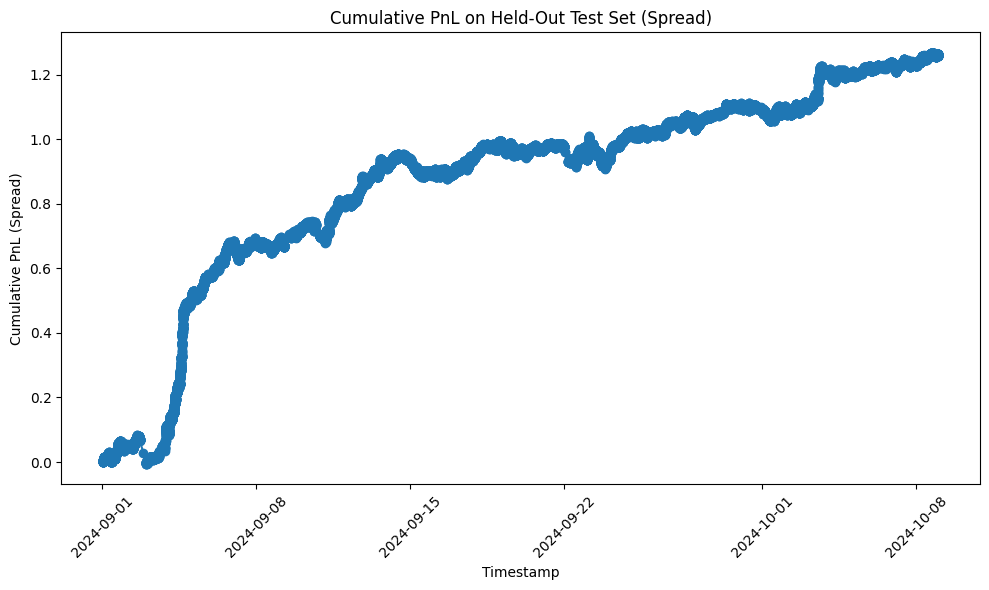

Test MSE (Close): 0.037357


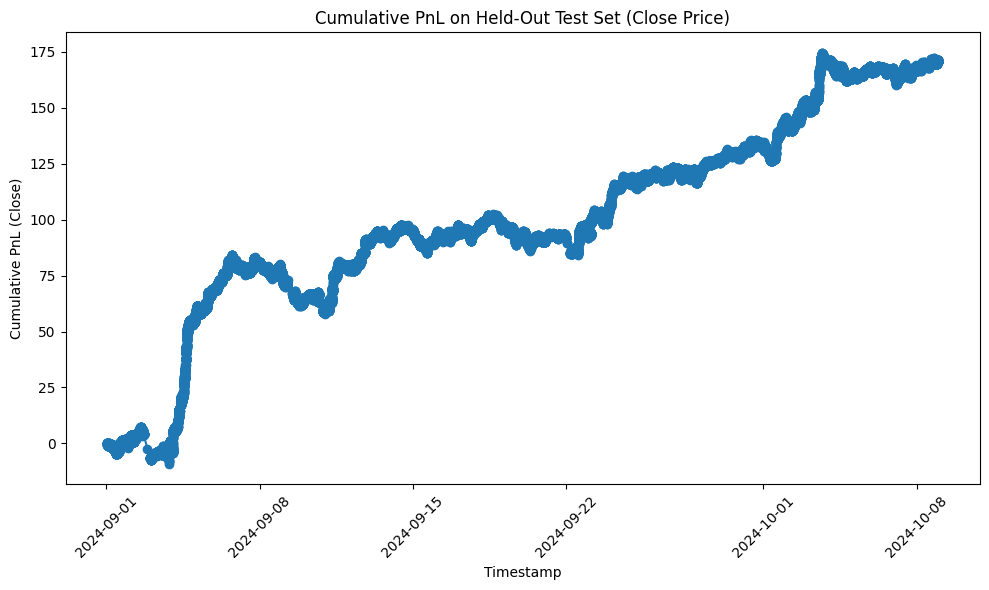

In [8]:
folds = create_expanding_splits(df, EVAL_WINDOWS, date_col="timestamp", gap_months=2)
fold_results = []
if folds:
    train_fold, val_fold = folds[0]
    # Use only selected features for training
    X_train_fold = train_fold[selected_features]
    y_train_fold = train_fold['target']
    X_val_fold = val_fold[selected_features]
    y_val_fold = val_fold['target']
    
    dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold)
    dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold)
    
    def objective(trial):
        params_trial = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'seed': 42
        }
        model_trial = xgb.train(params_trial, dtrain_fold, num_boost_round=500,
                                evals=[(dval_fold, 'eval')], early_stopping_rounds=10, verbose_eval=False)
        preds_trial = model_trial.predict(dval_fold)
        rmse_trial = mean_squared_error(y_val_fold, preds_trial, squared=False)
        return rmse_trial

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    best_params = study.best_trial.params
    print("Best hyperparameters (spread):", best_params)
else:
    best_params = {
        'eta': 0.1,
        'max_depth': 5,
        'min_child_weight': 1,
        'subsample': 1.0,
        'colsample_bytree': 1.0
    }
    print("No folds available for tuning; using default parameters.")

# best params
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42,
    **best_params
}

print("\nRolling Validation (Spread Target) Using Selected Features:")
for i, (train_df, val_df) in enumerate(folds):
    print(f"Fold {i+1}:")
    gap_info = f"(Training data up to {(EVAL_WINDOWS[i][0] - pd.DateOffset(months=2)).strftime('%Y-%m-%d')})"
    print("  " + gap_info)
    if val_df.empty:
        print(f"  Fold {i+1}: Validation set is empty. Skipping this fold.\n")
        continue
    print(f"  Validation period: {val_df['timestamp'].min()} to {val_df['timestamp'].max()}")
    
    X_train = train_df[selected_features]
    y_train = train_df['target']
    X_val = val_df[selected_features]
    y_val = val_df['target']
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    evals_list = [(dtrain, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrain, num_boost_round=1000,
                      evals=evals_list, early_stopping_rounds=20, verbose_eval=False)
    
    val_pred = model.predict(dval)
    mse_val = mean_squared_error(y_val, val_pred)
    print(f"  Fold {i+1} Validation MSE (Spread): {mse_val:.6f}\n")
    fold_results.append(mse_val)

if fold_results:
    print("Average Validation MSE across folds (Spread):", np.mean(fold_results))
else:
    print("No valid folds were found. Please adjust your validation windows.")

# Final evaluation

final_train_df = df[df['timestamp'] < (TEST_TIME_LOWER_BOUND - pd.DateOffset(months=2))]
X_all = final_train_df[selected_features]
y_all = final_train_df['target']
dall = xgb.DMatrix(X_all, label=y_all)

model_all = xgb.train(params, dall, num_boost_round=1000,
                      evals=[(dall, 'train')], early_stopping_rounds=20, verbose_eval=False)

test_df = get_data('test_data.csv')
test_df['timestamp'] = test_df['timestamp'].dt.floor('T')

test_df = pd.merge(test_df, sentiment_min, on='timestamp', how='left')
test_df['avg_sentiment'] = test_df['avg_sentiment'].fillna(0)
test_df = create_lag_features(test_df, 'spread', lags=LAGS)
test_df = create_lag_features(test_df, 'volume', lags=LAGS)
test_df = create_rolling_features(test_df, 'spread', window=5)
test_df = create_lag_features(test_df, 'avg_sentiment', lags=LAGS)
test_df['target'] = test_df['spread'].shift(-1) - test_df['spread']
test_df['target_close'] = test_df['close'].shift(-1) - test_df['close']
test_df.dropna(inplace=True)

X_test = test_df[selected_features]
y_test = test_df['target']
dtest = xgb.DMatrix(X_test, label=y_test)

test_pred = model_all.predict(dtest)
mse_test = mean_squared_error(y_test, test_pred)
print(f"\nTest MSE (Spread): {mse_test:.6f}")

# Spread
test_df['predicted_return'] = test_pred
test_df['pos_size'] = np.where(test_df['predicted_return'] > 0, 1, -1)
test_df = pnl(test_df, pos_col='pos_size', price_col='spread')

plt.figure(figsize=(10, 6))
plt.plot(test_df['timestamp'], test_df['cumulative_pnl'], marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative PnL (Spread)')
plt.title('Cumulative PnL on Held-Out Test Set (Spread)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Train & Eval on close
# For the close target, we use the same selected features for the sake of simplicity
X_all_close = final_train_df[selected_features]
y_all_close = final_train_df['target_close']
dall_close = xgb.DMatrix(X_all_close, label=y_all_close)

model_all_close = xgb.train(params, dall_close, num_boost_round=1000,
                            evals=[(dall_close, 'train')], early_stopping_rounds=20, verbose_eval=False)

X_test_close = test_df[selected_features]
y_test_close = test_df['target_close']
dtest_close = xgb.DMatrix(X_test_close, label=y_test_close)

test_pred_close = model_all_close.predict(dtest_close)
mse_test_close = mean_squared_error(y_test_close, test_pred_close)
print(f"Test MSE (Close): {mse_test_close:.6f}")

# Trading evaluation for close target:
test_df['predicted_return_close'] = test_pred_close
test_df['pos_size_close'] = np.where(test_df['predicted_return_close'] > 0, 1, -1)
test_df_close = test_df.copy()
test_df_close = pnl(test_df_close, pos_col='pos_size_close', price_col='close')

plt.figure(figsize=(10, 6))
plt.plot(test_df_close['timestamp'], test_df_close['cumulative_pnl'], marker='o')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative PnL (Close)')
plt.title('Cumulative PnL on Held-Out Test Set (Close Price)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
